In [2]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [52]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
german_stopwords = set(stopwords.words('german'))

In [5]:
SEED=42

In [6]:
df = pd.read_parquet("../data/de_poems.parquet")
df = df.astype({"title": "string", "text": "string", "author": "string", "creation": "int64"})
df.dtypes

title       string[python]
text        string[python]
author      string[python]
creation             int64
dtype: object

In [7]:
df["century"] = (df["creation"] // 100) + 1

In [8]:
def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[\d\W_]+', ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in german_stopwords]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].map(preprocess)

In [26]:
X = df['cleaned_text'].values
y = df['century'].values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [53]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,1), max_df=0.9, min_df=3)),
    ('select', SelectKBest(chi2, k=6000)),
    ('bag', BalancedBaggingClassifier(
        estimator=LogisticRegression(
            max_iter=1000,
            class_weight='balanced'
        ),
        n_estimators=20,
        bootstrap=True,
        random_state=SEED
    ))
])

In [54]:
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'select__k': [1000, 2000, 3000, 4000, 5000],
    'bag__n_estimators': [3, 10, 20],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=4
)

In [55]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9, min_df=3)),
                                       ('select',
                                        SelectKBest(k=6000,
                                                    score_func=<function chi2 at 0x74bd0f45c4a0>)),
                                       ('bag',
                                        BalancedBaggingClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                                               max_iter=1000),
                                                                  n_estimators=20,
                                                                  random_state=42))]),
             n_jobs=4,
             param_grid={'bag__n_estimators': [3, 10, 20],
                         'select__k': [1000, 2000, 3000, 4000, 5000],
                         'tfidf__max_df': [0.8, 0.9, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

In [56]:
y_pred = grid.predict(X_test)
print("Best Parameters:", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'bag__n_estimators': 20, 'select__k': 5000, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 2)}

Classification Report:
               precision    recall  f1-score   support

          11       0.15      0.53      0.23        55
          13       0.09      0.67      0.17        18
          14       0.24      0.75      0.36       189
          16       0.48      0.77      0.59       210
          17       0.80      0.75      0.77      4032
          18       0.60      0.41      0.49      2880
          19       0.82      0.38      0.52      6476
          20       0.09      0.86      0.16       454

    accuracy                           0.52     14314
   macro avg       0.41      0.64      0.41     14314
weighted avg       0.73      0.52      0.57     14314



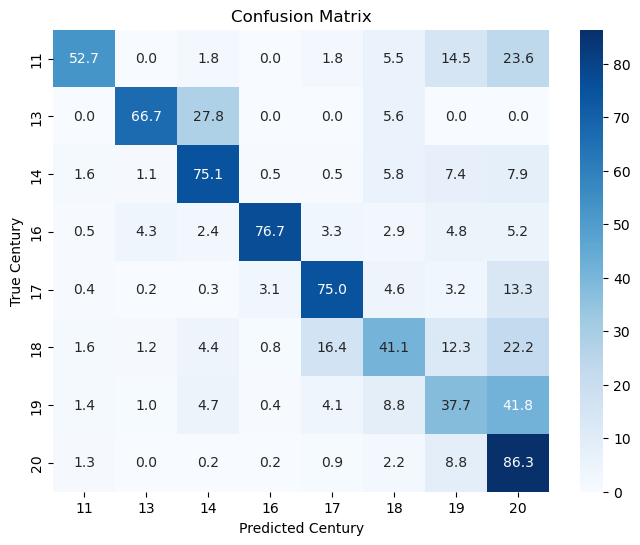

In [57]:
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

centuries = sorted(np.unique(np.concatenate((y_test, y_pred))))

plt.figure(figsize=(8,6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues', xticklabels=centuries, yticklabels=centuries)
plt.xlabel('Predicted Century')
plt.ylabel('True Century')
plt.title('Confusion Matrix')
plt.show()